In [1]:
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using IntervalSets
using Random 
using ArraysOfArrays
using ValueShapes
using Measurements
using BAT 
using MultivariateStats
using Clustering
using PyPlot

# PDF:

In [2]:
Σ = [3.426818298733095 12.378238116671048 -9.632531611142456; 
    12.378238116671048 69.83909693165143 -43.478993858310886; 
    -9.632531611142456 -43.478993858310886 60.0626256206892]

μ = [8.959570984309234, -9.021529871694005, -5.007789383392622]

n_dims = 3 

distribution = MvNormal(μ, Σ)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

In [70]:
n_dims = 10

distribution = BAT.FunnelDistribution(n=n_dims)

prior = NamedTupleDist(
    x = repeat([-50.0 .. 50.0], n_dims),
);

# MCMC Sampling: 

In [71]:
log_likelihood = let dist = distribution
    params -> begin
        LogDVal(logpdf(dist, params.x))
    end
end

posterior = PosteriorDensity(log_likelihood, prior);

In [85]:
nsamples = 10^6

# samples = bat_sample(
#     posterior, 
#     nsamples, MCMCSampling(sampler = MetropolisHastings(), nchains = 4)
# ).result; # MCMCSampling(sampler = MetropolisHastings(), nchains = 4)

samples = bat_sample(
    distribution, 
    nsamples, IIDSampling()).result; 

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44


In [86]:
i_ahmi = log(bat_integrate(samples).result)

┌ Info: Using integration algorithm AHMIntegration{CholeskyPartialWhitening,GeyerAutocorLen}
│   whitening: CholeskyPartialWhitening CholeskyPartialWhitening()
│   autocorlen: GeyerAutocorLen GeyerAutocorLen()
│   volumetype: Symbol HyperRectangle
│   max_startingIDs: Int64 10000
│   max_startingIDs_fraction: Float64 2.5
│   rect_increase: Float64 0.1
│   warning_minstartingids: Int64 16
│   dotrimming: Bool true
│   uncertainty: Array{Symbol}((1,))
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 499999	Parameters:	10
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:93
┌ Info: Data Whitening.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:108
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/integration/ahmi/harmonic

0.052 ± 0.017

# Functions: 

In [87]:
function find_steep_edges(smpl::AbstractArray, w::AbstractArray; α=0.01)
    hist_weights = fit(Histogram, smpl, weights(w), nbins=100).weights
    max_weight = maximum(hist_weights)
    if hist_weights[1] < α*max_weight && hist_weights[end] < α*max_weight
        return false
    else
        return true
    end
end


function find_whiten_trans(smpl::AbstractArray, w::AbstractArray; edges=zeros(Bool, size(smpl)[1]))
      
    μ = mean(smpl, dims=2)
    
    cov_m = cov(smpl .- μ, FrequencyWeights(w), 2)
    
    for (ind, edge) in enumerate(edges)
        if edge 
            tmp_vals = cov_m[ind,ind]
            cov_m[:,ind] .= 0.0
            cov_m[ind,:] .= 0.0
            cov_m[ind,ind] = tmp_vals
        end
    end
    
    L = eigvals(cov_m)
    E = eigvecs(cov_m)
    W = E'
    W = W ./ sqrt.(L .+ 1e-4)
    
    return(W = W, μ=μ)
    
end

function apply_whiten_trans(smpl::AbstractArray, W::AbstractMatrix, μ::AbstractArray)
    return W*(smpl .- μ)
end

function apply_clustering(smpl::AbstractArray, w::AbstractArray, n_clusters::Integer)
    return kmeans(smpl, n_clusters, weights=w)
end

function find_volume(smpl::AbstractArray, w::AbstractArray, ll::AbstractArray, clust_center::AbstractArray)
    size_cube = 1.
    vol = (2*size_cube)^size(smpl)[1]
    mask = prod(-size_cube .< smpl .< size_cube, dims=1 )[1,:]
    return(mask = mask, vol = vol)
end

function compute_hm(smpl::AbstractArray, w::AbstractArray, ll::AbstractArray, mask::AbstractArray, vol::AbstractFloat, det1::AbstractFloat, det2::AbstractFloat)
    r = sum(w[mask]) / sum(w) 
    x = mean(1 ./ exp.(ll[mask]), weights(w[mask]))
    i_r = vol / (x*det1*det2)
    
    return  i_r / r
end

compute_hm (generic function with 1 method)

## Integration: 

In [93]:
smpl_v = collect(flatview(unshaped.(samples.v)))
smpl_w = samples.weight

log_d_minimum = minimum(samples.logd )
smpl_ld = samples.logd .- log_d_minimum # subtract constant pedestal;

# *** initialize samples: 

steep_edges = [find_steep_edges(row, smpl_w) for row in eachrow(smpl_v)]
whiten_init_w, whiten_init_μ = find_whiten_trans(smpl_v, smpl_w, edges=steep_edges)
smpl_v = apply_whiten_trans(smpl_v, whiten_init_w, whiten_init_μ)

integral_estimates = Float64[]
samples_subspaes = []
samples_volumes= []
samples_clusters = []

n_clusters = 50

clusters = apply_clustering(smpl_v, smpl_w, n_clusters)

for clust_ind in 1:n_clusters
    mask_cluster = clusters.assignments .== clust_ind
    whiten_tmp_w, whiten_tmp_μ = find_whiten_trans(smpl_v[:,mask_cluster], smpl_w[mask_cluster]) #edges=steep_edges
    smpl_tmp = apply_whiten_trans(smpl_v, whiten_tmp_w, whiten_tmp_μ)

    cluster_center = whiten_tmp_w * clusters.centers[:,clust_ind]
    mask_volume, volume = find_volume(smpl_tmp[:,mask_cluster], smpl_w[mask_cluster], smpl_ld[mask_cluster], cluster_center)

    push!(samples_subspaes, smpl_tmp[:,mask_cluster])
    mask_cluster[mask_cluster .== 1] .= mask_volume
    hm_estimate = compute_hm(smpl_tmp, smpl_w, smpl_ld, mask_cluster, volume, abs(det(whiten_init_w)), abs(det(whiten_tmp_w)))
    
    hm_estimate = log(hm_estimate) + log_d_minimum
    
    push!(integral_estimates, hm_estimate)
    push!(samples_volumes, [mask_cluster])
    push!(samples_clusters, [mask_volume]) 
end



In [94]:
integral_estimates

50-element Array{Float64,1}:
   0.4217173988229206
   0.005863681719219471
   0.024808233180721118
   0.0870749569963607
  -0.2144377674093647
   0.09967615941076247
   0.024288214725586954
   0.2937055206952266
   0.15933709275002172
  -0.6268703912220133
  -0.4641378251958912
   0.2318053089340424
  -0.14677934501933976
   ⋮
  -0.02989248133563649
   0.06223000647997878
   0.14978908811247038
  -0.07037012918718233
  -0.025921105908210507
   0.06074223385321886
   0.0032564884458849974
   0.14210640311229383
  -1.0072949814428114
   0.4961206199402284
   0.011305256164206412
 NaN

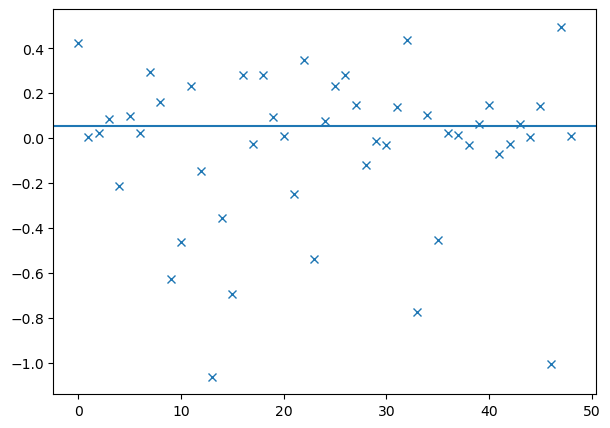

PyObject <matplotlib.lines.Line2D object at 0x7fd380229130>

In [95]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ax.plot(integral_estimates, "x")
ax.axhline([i_ahmi.val], )
ax.axhline([mean(integral_estimates)], color="red", linestyle = "--")

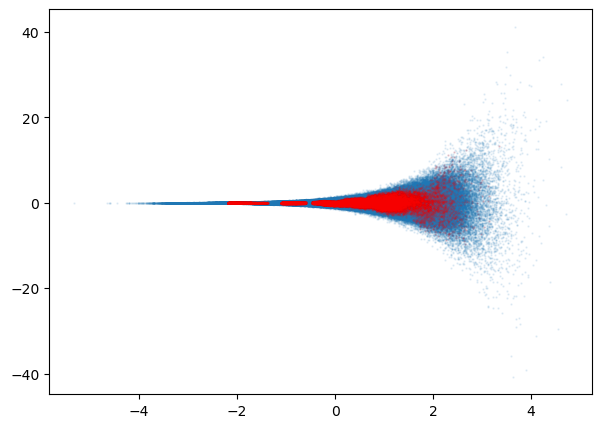

In [100]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.scatter(smpl_v[1,:], smpl_v[2,:], color="C0", alpha=0.1, s=0.5,)

for iii in samples_volumes
    ax.scatter(smpl_v[1,iii...], smpl_v[2,iii...], color="red", s=0.7,  alpha=0.1)
end

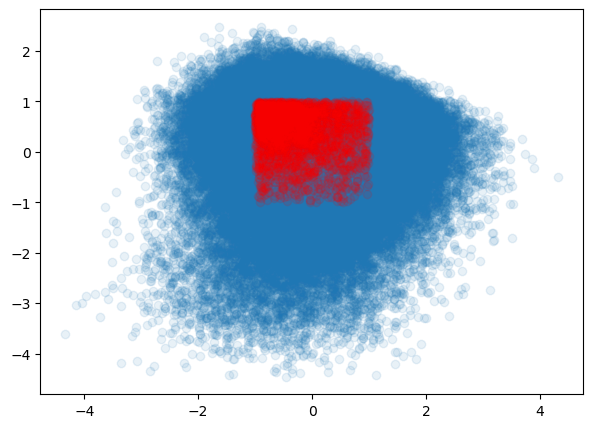

PyObject <matplotlib.collections.PathCollection object at 0x7fd4322ff730>

In [101]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

ii = 2

ax.scatter(samples_subspaes[ii][1,:], samples_subspaes[ii][2,:], color="C0", alpha=0.1)

ax.scatter(samples_subspaes[ii][1,samples_clusters[ii]...], samples_subspaes[ii][2,samples_clusters[ii]...], color="red", alpha=0.1)